This notebook introduces the fundamental objects of `MDAnalysis`: the `Universe`, `AtomGroup`, and `Atom` objects. It also introduces the selection language, and the basics of reading and slicing trajectories.

# 1. Fundamental objects

## `Universes` and `AtomGroups`

> "If you wish to make an apple pie from scratch, you must first invent the Universe." 

> ~ Carl Sagan

One of the fundamental objects in the `MDAnalysis` data model is the `Universe` object. This contains all of a simulations' topology information at the least, but usually also includes trajectory information as well. A `Universe` can be thought of as an interface to the raw details of a simulation.

First, we need to import `MDAnalysis`, giving us access to all the components in its namespace:

In [1]:
import MDAnalysis as mda
import MDAnalysisData as data
print(mda.__version__)
print(data.__version__)

0.19.0
0.3.0+10.g224b7fe


In order to do anything, we do need some actual molecular dynamics data to work with.
You should have downloaded a dataset package for this workshop;
Let's load a dataset.

In [9]:
adk_dataset = data.datasets.fetch_adk_equilibrium()
print(adk_dataset['DESCR'])

.. -*- coding: utf-8 -*-

.. _`adk-equilibrium-dataset`:

AdK equilibrium trajectory dataset

MD trajectory of apo adenylate kinase with CHARMM27 force field and
simulated with explicit water and ions in NPT at 300 K and 1
bar. Saved every 240 ps for a total of 1.004 µs. Produced on PSC
Anton. The trajectory only contains the protein while all solvent was
stripped in order to reduce the trajectory size. The whole protein was
superimposed on the CORE domain of AdK by RMSD fitting.

The topology is contained in the PSF file (CHARMM format). The
trajectory is contained in the DCD file (CHARMM/NAMD format).


Notes
-----

Data set characteristics:

 :size: 161 MB
 :number of trajectories: 1
 :number of frames:  4187
 :number of particles: 3341
 :creator: Sean Seyler
 :URL:  `10.6084/m9.figshare.5108170.v1 <https://doi.org/10.6084/m9.figshare.5108170.v1>`_
 :license: `CC-BY 4.0 <https://creativecommons.org/licenses/by/4.0/legalcode>`_
 :reference: [Seyler2017]_
    

.. [Seyler2017]  Seyler

To make a Universe, we need at the very least a topology file. We'll use one for a simulation system that includes adenylate kinase with the water removed:

In [7]:
u = mda.Universe(adk_dataset['topology'])

print(u)

<Universe with 3341 atoms>


We now have a `Universe` object. Since the topology (PSF) file we loaded contained both atom identities and bond information, the `Universe` is able to access these details.

We can access all atoms in the `Universe` through the `Universe.atoms` attribute. This gives access to many details, including basic topology details for each atom.

In [10]:
u.atoms.indices

array([   0,    1,    2, ..., 3338, 3339, 3340])

In [11]:
u.atoms.names

array(['N', 'HT1', 'HT2', ..., 'CA', 'HA1', 'HA2'], dtype=object)

In [12]:
u.atoms.resnames

array(['MET', 'MET', 'MET', ..., 'GLY', 'GLY', 'GLY'], dtype=object)

In [13]:
u.atoms.resids

array([  1,   1,   1, ..., 214, 214, 214])

In [14]:
u.atoms.charges

array([-0.30000001,  0.33000001,  0.33000001, ..., -0.02      ,
        0.09      ,  0.09      ])

In [15]:
u.atoms.masses

array([14.007,  1.008,  1.008, ..., 12.011,  1.008,  1.008])

In [16]:
u.atoms.types

array(['NH3', 'HC', 'HC', ..., 'CT2', 'HB', 'HB'], dtype=object)

These are all properties of an `AtomGroup`, of which `Universe.atoms` is one such instance.

In [17]:
type(u.atoms)

MDAnalysis.core.groups.AtomGroup

Many of the methods of an `AtomGroup` return numpy arrays of the same length as the `AtomGroup` itself; that is, each element corresponds to each atom in the `AtomGroup`, in order. That means that if we want only, say, the masses of the 3rd through the 11th atom in our topology, we could simply slice like so:

In [20]:
u.atoms.masses[2:11]

array([ 1.008,  1.008, 12.011,  1.008, 12.011,  1.008,  1.008, 12.011,
        1.008])

**Note**: `AtomGroup` indexes are 0-based, even if the topology file gives the atoms 1-based indices. This is for consistency with the rest of the Python ecosystem, including `numpy`. 

But `AtomGroup`s themselves are actually sliceable, so we could instead do:

In [21]:
u.atoms[2:11].masses

array([ 1.008,  1.008, 12.011,  1.008, 12.011,  1.008,  1.008, 12.011,
        1.008])

to achieve the same effect. Slicing of an `AtomGroup` returns an `AtomGroup` containing the atoms in the slice, so this gives a basic way of accessing a subset of the atoms present in the topology.

Fancy indexing also works. We can, for example, get an `AtomGroup` containing the 3rd, 22nd, 3rd, and second-to-last atom in the `Universe` with something like:

In [24]:
ag = u.atoms[[2, 21, 2, -2]]

In [25]:
ag.indices

array([   2,   21,    2, 3339])

We can also use expressions that return boolean arrays to select out atoms of interest. We can, for exmple, get an `AtomGroup` of all atoms in the system with mass less than 10 u with:

In [27]:
u.atoms[u.atoms.masses < 10]

<AtomGroup with 1685 atoms>

We can string together boolean expressions to obtain even more granular selections, for example getting all atoms with mass less than 10 u AND within an arginine residue:

In [29]:
u.atoms[(u.atoms.masses < 10) & (u.atoms.resnames == 'ARG')]

<AtomGroup with 169 atoms>

All topology properties of an `AtomGroup` can be harnessed in this way to make complex subselections.

## Working with individual atoms

We can also work with individual atoms, though in practice this is rare, and in the future will be relatively inefficient when operating on multiple atoms compared to operating on a whole `AtomGroup`. At the moment, however, these operations are comparable in speed.

In [30]:
a = u.atoms[0]
print(a)

<Atom 1: N of type NH3 of resname MET, resid 1 and segid ADK>


In [31]:
print("name:", a.name)
print("resid:", a.resid)
print("resname:", a.resname)

name: N
resid: 1
resname: MET


### Challenge: count the number of glycine residues in the protein

In [32]:
import numpy as np

In [33]:
r = u.atoms[u.atoms.resnames == 'GLY'].resids

In [34]:
len(np.unique(r))

20

## `ResidueGroups` and `SegmentGroups`

The `Universe` also gives higher-order topology objects, including `ResidueGroups` and `SegmentGroups`. We can access all residues in the `Universe` with:

In [35]:
u.residues

<ResidueGroup with 214 residues>

And all segments with:

In [36]:
u.segments

<SegmentGroup with 1 segment>

`ResidueGroups` and `SegmentGroups` also behave similarly to `AtomGroups`, with many of their methods returning `numpy` arrays with each element corresponding to a single residue or segment, respectively.

In [37]:
u.residues.resnames

array(['MET', 'ARG', 'ILE', 'ILE', 'LEU', 'LEU', 'GLY', 'ALA', 'PRO',
       'GLY', 'ALA', 'GLY', 'LYS', 'GLY', 'THR', 'GLN', 'ALA', 'GLN',
       'PHE', 'ILE', 'MET', 'GLU', 'LYS', 'TYR', 'GLY', 'ILE', 'PRO',
       'GLN', 'ILE', 'SER', 'THR', 'GLY', 'ASP', 'MET', 'LEU', 'ARG',
       'ALA', 'ALA', 'VAL', 'LYS', 'SER', 'GLY', 'SER', 'GLU', 'LEU',
       'GLY', 'LYS', 'GLN', 'ALA', 'LYS', 'ASP', 'ILE', 'MET', 'ASP',
       'ALA', 'GLY', 'LYS', 'LEU', 'VAL', 'THR', 'ASP', 'GLU', 'LEU',
       'VAL', 'ILE', 'ALA', 'LEU', 'VAL', 'LYS', 'GLU', 'ARG', 'ILE',
       'ALA', 'GLN', 'GLU', 'ASP', 'CYS', 'ARG', 'ASN', 'GLY', 'PHE',
       'LEU', 'LEU', 'ASP', 'GLY', 'PHE', 'PRO', 'ARG', 'THR', 'ILE',
       'PRO', 'GLN', 'ALA', 'ASP', 'ALA', 'MET', 'LYS', 'GLU', 'ALA',
       'GLY', 'ILE', 'ASN', 'VAL', 'ASP', 'TYR', 'VAL', 'LEU', 'GLU',
       'PHE', 'ASP', 'VAL', 'PRO', 'ASP', 'GLU', 'LEU', 'ILE', 'VAL',
       'ASP', 'ARG', 'ILE', 'VAL', 'GLY', 'ARG', 'ARG', 'VAL', 'HSE',
       'ALA', 'PRO',

In [38]:
u.segments.segids

array(['ADK'], dtype=object)

We can more easily get the number of glycine residues using a `ResidueGroup`.

In [39]:
u.atoms[u.atoms.resnames == 'GLY'].residues.n_residues

20

or perhaps more Pythonic:

In [40]:
len(u.atoms[u.atoms.resnames == 'GLY'].residues)

20

## Using coordinates

`AtomGroups` are more interesting with coordinate data attached to them. Our topology file has none of this, so using

In [41]:
u.atoms.positions

AttributeError: AtomGroup has no attribute positions

yields an `AttributeError`. Let's load some coordinates by creating a new Universe, but with a topology + a trajectory.

In [44]:
u = mda.Universe(adk_dataset['topology'], adk_dataset['trajectory'])

Now this will work.

In [45]:
u.atoms.positions

array([[ 2.8706636, 10.604456 ,  9.750288 ],
       [ 3.109205 , 11.324709 ,  9.038997 ],
       [ 3.7460954, 10.243008 , 10.179911 ],
       ...,
       [-7.499353 , 10.892199 , 12.3347645],
       [-6.5965843, 10.8342705, 12.924728 ],
       [-8.348269 , 10.599268 , 12.934707 ]], dtype=float32)

### Challenge: calculate the center of geometry of the C$_\alpha$ atoms

In [46]:
u.atoms[u.atoms.names == 'CA'].positions.mean(axis=0)

array([ 1.0424447,  2.2344341, -5.152382 ], dtype=float32)

Alternatively, we have a builtin for this:

In [47]:
u.atoms[u.atoms.names == 'CA'].centroid()

array([ 1.04244519,  2.23443222, -5.15238301])

## Bonds, angles, and dihedrals

We can also get at connectivity information between atoms, such as bonds, angles, and dihedrals.

In [48]:
u.bonds

<TopologyGroup containing 3365 bonds>

In [49]:
u.angles

<TopologyGroup containing 6123 angles>

In [50]:
u.dihedrals

<TopologyGroup containing 8921 dihedrals>

In [51]:
u.bonds[3]

<Bond between: Atom 0, Atom 4>

Want the actual value?

In [52]:
u.bonds[3].value()

1.4905601980938534

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  23.,  295.,   57.,  287., 1022.,    0.,    0.,   31.,  105.,
         126.,   41.,   71.,  114.,   88.,   81.,  101.,  129.,  186.,
         255.,  221.,  102.,   15.,    2.,    0.,    0.,    0.,    4.,
           2.,    3.,    4.]),
 array([0.95999745, 0.99054587, 1.02109429, 1.05164271, 1.08219113,
        1.11273955, 1.14328797, 1.17383639, 1.20438481, 1.23493323,
        1.26548165, 1.29603007, 1.32657849, 1.35712691, 1.38767533,
        1.41822375, 1.44877217, 1.47932059, 1.50986901, 1.54041743,
        1.57096585, 1.60151427, 1.63206269, 1.66261111, 1.69315953,
        1.72370795, 1.75425637, 1.78480479, 1.81535321, 1.84590163,
        1.87645005]),
 <a list of 30 Patch objects>)

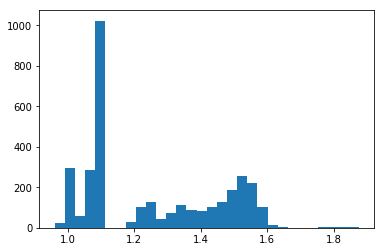

In [54]:
plt.hist(u.bonds.values(), bins=30)

These work the same way as `AtomGroup`s. They're sliceable, and indexing them works too to give individual bonds, angles, dihedrals.

# 2. Selecting atoms with selection strings

We've already seen that complex selections can be performed on `AtomGroups` through boolean array indexing. However, `MDAnalysis` also features a CHARMM-style atom selection mechanism that is often more convenient.

In [56]:
u.atoms.select_atoms?

Although boolean selections work well enough for selecting out atoms from AtomGroups, the selection language makes more complex selections possible with probably less effort. For example, we can selections of the 

In [57]:
acidic = u.select_atoms("(resname GLU or resname ASP)")
acidic

<AtomGroup with 474 atoms>

In [61]:
acidic_o = acidic.select_atoms('(name OD* or name OE*)')
acidic_o

<AtomGroup with 70 atoms>

As a shortcut, multiple values can be given and these will be implicitly OR'd together.
For example to select all atoms with name NZ OR NH* in residues named LYS or ARG:

In [63]:
basic_n = u.select_atoms( "((resname LYS ARG) and (name NZ NH*))")
basic_n

<AtomGroup with 44 atoms>

If we want only residues that are involved in salt bridges, we can use our `AtomGroups` as part of additional selections. We can also use the `around` selection operator to specify only atoms within 4 angstroms. At the end we can get the full residues back.

In [64]:
acidic_res = u.select_atoms("group acidic and around 4 group basic", acidic=acidic_o, basic=basic_n).residues
basic_res = u.select_atoms("group basic and around 4 group acidic", acidic=acidic_o, basic=basic_n).residues

We can write these selections out into a variety of formats; in particular we can output as a VMD selection.

In [66]:
# addition of AtomGroups yields an AtomGroup
(acidic_res + basic_res).atoms.write('saltbridge.vmd', name='saltbridge')

Then load into VMD

    source saltbridge.vmd

and use the new named selection "saltbridge" in *Representations*.

### Example: domain movement of adenylate kinase (AdK)

AdK has three domains: CORE, NMP, LID. The NMP and LID move relative to the CORE. Movements can be defined by two angles between the two domains, $\theta_{\text{NMP}}$ and $\theta_{\text{LID}}$.

These angles are defined as:
* CORE residues 1-29, 60-121, 160-214 (gray)
* NMP residues 30-59 (blue)
* LID residues 122-159 (yellow)

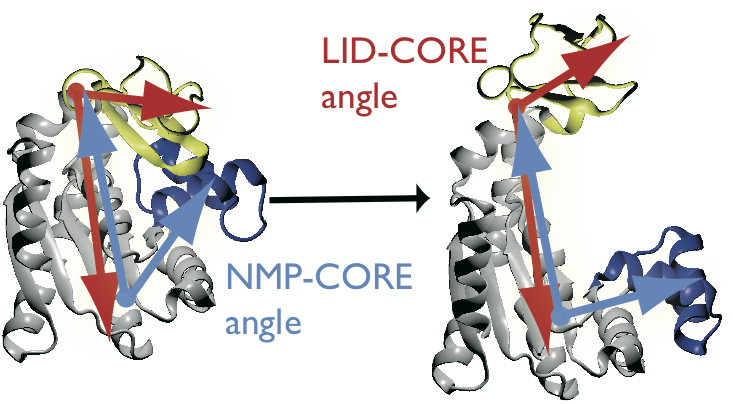

In [92]:
from IPython.core.display import Image

Image("MDAnalysisTutorial/doc/sphinx/figs/angle_defs.png")

AdK undergoes a conformational transition during which the NMP and LID domain move relative to the CORE domain. The transition can be characterized by the angles between the domains:

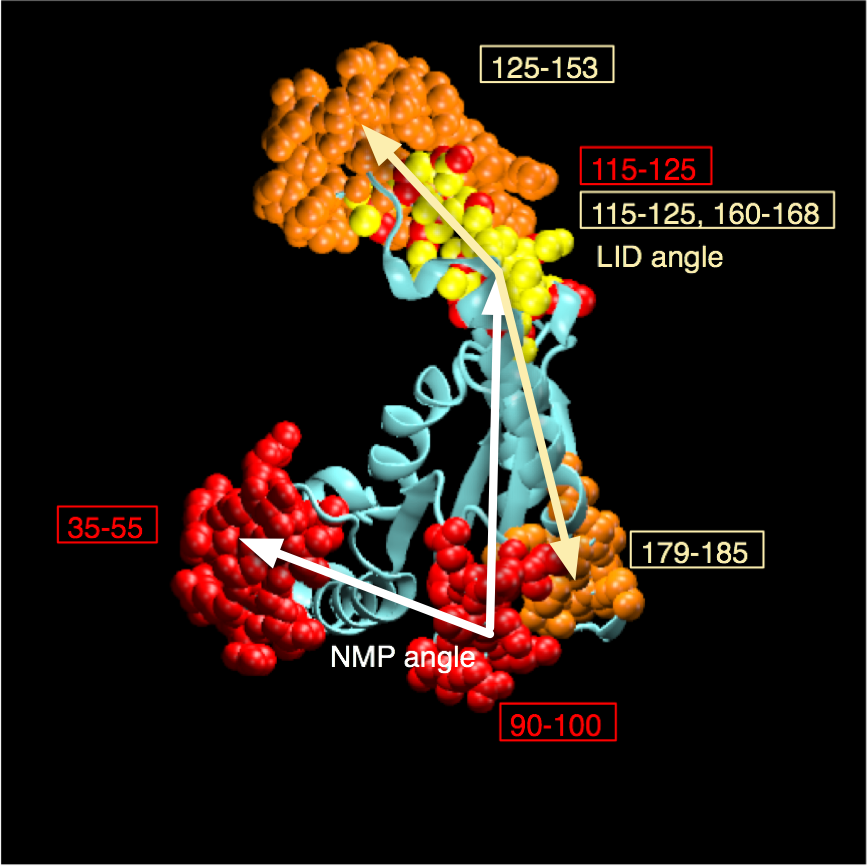

In [93]:
Image("MDAnalysisTutorial/doc/sphinx/figs/6b_angle_def_open.png", width=500)

For simplicity, define $\theta_{\text{NMP}}$ and $\theta_{\text{LID}}$ between the centers of mass of *backbone* atoms of groups of the following atoms `A`, `B`, `C`:

Definition of $\theta_{\text{NMP}}$

A: 115-125, B: 90-100, C: 35-55

Definition of $\theta_{\text{LID}}$

A: 179-185, B: 115-125, C: 125-153

The angle between vectors $\vec{BA}$ and $\vec{BC}$ is \begin{equation*} \theta = \arccos\left(\frac{\vec{BA}\cdot\vec{BC}}{|\vec{BA}||\vec{BC}|}\right) \end{equation*}

With `numpy`:
```python
np.arccos(np.cdot(BA, BC))/(np.linalg.norm(BA) * np.linalg.norm(BC))
```


Write two functions `theta_NMP()` and `theta_LID()` that calculate these angles, given the universe.

Hint:

In [69]:
A = u.select_atoms("resid 115:125 and backbone").center_of_geometry()

In [70]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(u):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 115:125 and backbone").center_of_geometry()
    B = u.select_atoms("resid 90:100 and backbone").center_of_geometry()
    A = u.select_atoms("resid 35:55 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(u):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = u.select_atoms("resid 179:185 and backbone").center_of_geometry()
    B = u.select_atoms("resid 115:125 and backbone").center_of_geometry()
    A = u.select_atoms("resid 125:153 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

And now Oliver.